Dataset does not contain null values.
Epoch [1/250], Train Loss: 1606641.3660, Test Loss: 974871.3750
Epoch [2/250], Train Loss: 1569936.8840, Test Loss: 946632.8750
Epoch [3/250], Train Loss: 1534232.6520, Test Loss: 918795.6250
Epoch [4/250], Train Loss: 1498973.4257, Test Loss: 891514.8125
Epoch [5/250], Train Loss: 1464540.2196, Test Loss: 865070.8750
Epoch [6/250], Train Loss: 1431006.8209, Test Loss: 839398.1250
Epoch [7/250], Train Loss: 1398302.9347, Test Loss: 814442.0625
Epoch [8/250], Train Loss: 1366369.1768, Test Loss: 790159.1250
Epoch [9/250], Train Loss: 1335161.3119, Test Loss: 766517.1875
Epoch [10/250], Train Loss: 1304646.4741, Test Loss: 743492.1250
Epoch [11/250], Train Loss: 1274799.7883, Test Loss: 721064.1250
Epoch [12/250], Train Loss: 1245601.1070, Test Loss: 699217.0000
Epoch [13/250], Train Loss: 1217033.6791, Test Loss: 677936.5000
Epoch [14/250], Train Loss: 1189082.6745, Test Loss: 657209.8750
Epoch [15/250], Train Loss: 1161735.1712, Test Loss: 637025.4

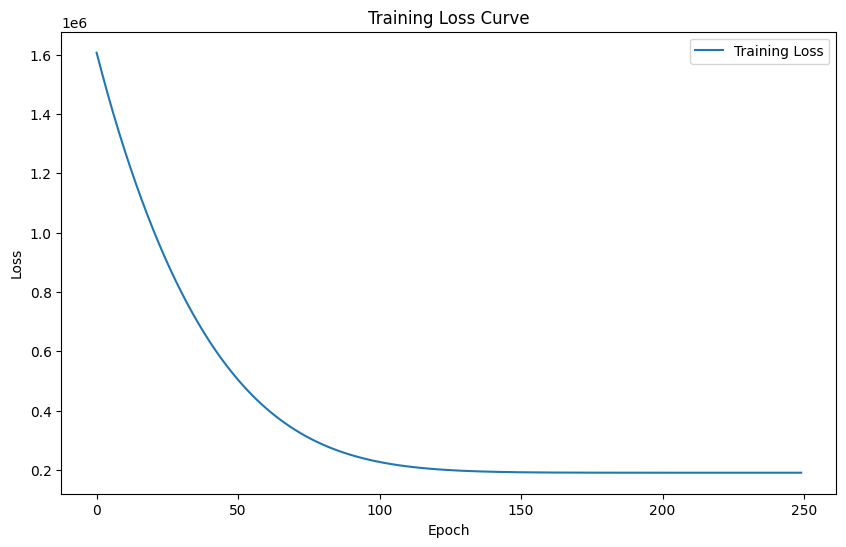

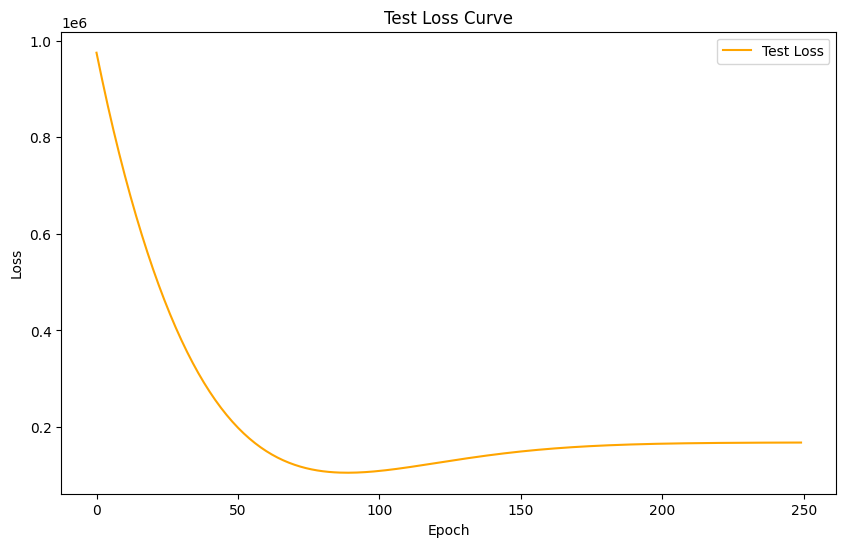

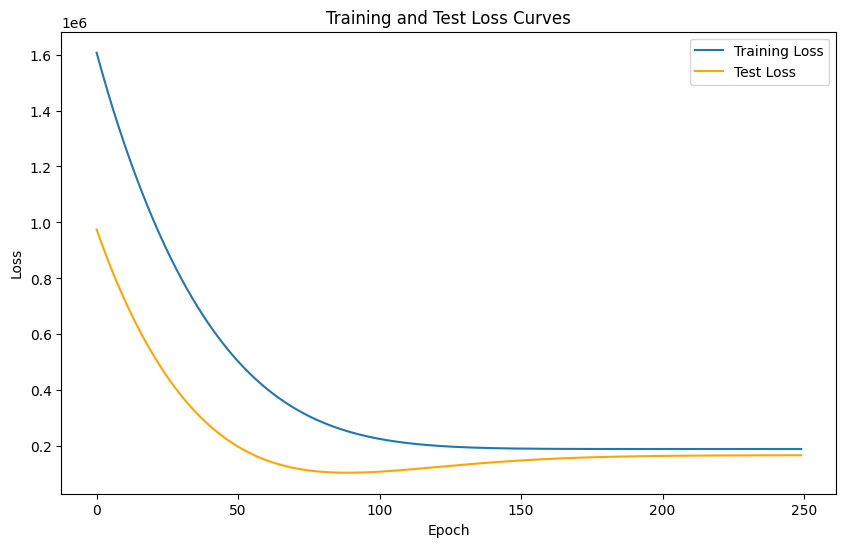

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/FinalProjectDataS23.csv')

# Standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['rate', 'ems', 'pkh']])

# Checking for null values
if data.isnull().any().any():
    print("Dataset contains null values. Handling them appropriately.")
    # Handle null values here (imputation or removal)
else:
    print("Dataset does not contain null values.")

# Define window size and split the dataset
window_size = 10
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences and targets
def create_sequences_and_targets(data, window_size, train=True):
    sequences, targets = [], []
    start_index = window_size if train else len(data) - window_size

    for i in range(start_index, len(data)):
        sequence = data[i - window_size:i][['rate', 'ems', 'pkh']].values
        target = data.iloc[i]['pkh']
        sequences.append(sequence)
        targets.append(target)

    return sequences, targets

train_sequences, train_targets = create_sequences_and_targets(train_data, window_size)
test_sequences, test_targets = create_sequences_and_targets(test_data, window_size, train=False)

train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

# Define the multi-layered LSTM model
class MultiLayerLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model
input_size = 3  # rate, ems, pkh
hidden_size = 128
num_layers = 3
output_size = 1  # predicting pkh
model = MultiLayerLSTMModel(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 250
batch_size = 16

train_losses = []
test_losses = []
best_train_loss = float('inf')
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0.0
    for i in range(0, len(train_sequences), batch_size):
        batch_sequences = train_sequences[i:i+batch_size]
        batch_targets = train_targets[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * len(batch_sequences)

    train_loss = epoch_train_loss / len(train_sequences)
    train_losses.append(train_loss)

    # Evaluate on test dataset
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_targets.unsqueeze(1))
        test_losses.append(test_loss.item())

    # Track best losses
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Print best losses
print(f'Best Train Loss: {best_train_loss:.4f}, Best Test Loss: {best_test_loss:.4f}')

# Calculate RMSE for training and test sets
train_rmse = torch.sqrt(torch.mean((model(train_sequences) - train_targets.unsqueeze(1))**2)).item()
test_rmse = torch.sqrt(torch.mean((model(test_sequences) - test_targets.unsqueeze(1))**2)).item()

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Plot training and test loss curves separately
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

# Plot both training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()
